MIC prediction for different drugs

In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.utils import to_categorical
# from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Load kmers
data = np.load('../data/interim/streptomycin/kmers/kmer_matrix.npz')
kmers = data['kmers']
kmer_order = data['kmer_order']
kmers.shape

(1406, 1922478)

In [3]:
mics = joblib.load("../data/interim/mic_class_dataframe.pkl")
mic_order = joblib.load("../data/interim/mic_class_order_dict.pkl")

In [4]:
# Join datasets
y = mics['AMP']
y = y.dropna(axis=0, how='any')
y = y.loc[y != 'invalid']
has_mic = np.in1d(kmer_order, y.index.values)
X_order = kmer_order[has_mic]
X = kmers[has_mic,:]
y = y[X_order]

In [5]:
# Encode remaining labels
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [6]:
# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=36)
print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3]), array([129,   9, 783, 485]))
(array([0, 1, 2, 3]), array([105,   7, 625, 387]))
(array([0, 1, 2, 3]), array([ 24,   2, 158,  98]))


In [7]:
# Filter selection
feature_selection = SelectKBest(f_classif, k=270)
feature_selection.fit(X_train, y_train)
X_train_fs = feature_selection.transform(X_train)
X_test_fs = feature_selection.transform(X_test)

In [8]:
# SVM Training
svm = LinearSVC(C=1, penalty='l1', dual=False)
svm.fit(X_train_fs,y_train)
y_svm = svm.predict(X_test_fs)

In [9]:
# SVM performance
print(accuracy_score(y_test,y_svm))
print(classification_report(y_test,y_svm))
print(confusion_matrix(y_test,y_svm))

0.8687943262411347
             precision    recall  f1-score   support

          0       0.36      0.42      0.38        24
          1       0.00      0.00      0.00         2
          2       0.90      0.89      0.89       158
          3       0.98      0.97      0.97        98

avg / total       0.87      0.87      0.87       282

[[ 10   0  13   1]
 [  1   0   1   0]
 [ 16   1 140   1]
 [  1   0   2  95]]


In [10]:
le.classes_

array(['2.0000', '4.0000', '<=1.0000', '>=32.0000'], dtype=object)

In [11]:
# Try to fit a model that does a good job predicting 2.0
y_train_bin = np.zeros(len(y_train))
y_train_bin[y_train == 0] = 1
y_test_bin = np.zeros(len(y_test))
y_test_bin[y_test == 0] = 1

feature_selection = SelectKBest(f_classif, k=270)
feature_selection.fit(X_train, y_train_bin)
X_train_bin = feature_selection.transform(X_train)
X_test_bin = feature_selection.transform(X_test)

from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.1, scale_pos_weight=10)
xgb.fit(X_train_bin,y_train_bin)
y_xgb_bin = xgb.predict(X_test_bin)

print(accuracy_score(y_test_bin, y_xgb_bin))
print(classification_report(y_test_bin, y_xgb_bin))
print(confusion_matrix(y_test_bin, y_xgb_bin))

# Find a FN and find its nearest neighbour
#y_xgb_bin != 

0.8297872340425532
             precision    recall  f1-score   support

        0.0       0.94      0.87      0.90       258
        1.0       0.21      0.38      0.27        24

avg / total       0.88      0.83      0.85       282

[[225  33]
 [ 15   9]]


/home/matt/anaconda3/envs/phenores4/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [44]:
# Try one of the more tricky ones
set1 = (y_train == 0) | (y_train == 2)
y_train_2 = y_train[set1]
X_train_2 = X_train[set1,:]
y_test_2 = y_test[(y_test == 0) | (y_test == 2)]
X_test_2 = X_test[(y_test == 0) | (y_test == 2),:]

feature_selection = SelectKBest(f_classif, k=270)
feature_selection.fit(X_train_2, y_train_2)
X_train_fs2 = feature_selection.transform(X_train_2)
X_test_fs2 = feature_selection.transform(X_test_2)

(1124,)

In [33]:
svm = LinearSVC(C=1, penalty='l1', dual=False)
svm.fit(X_train_fs2,y_train_2)
y_svm = svm.predict(X_test_fs2)

In [34]:
print(accuracy_score(y_test_2,y_svm))
print(classification_report(y_test_2,y_svm))
print(confusion_matrix(y_test_2,y_svm))

0.8076923076923077
             precision    recall  f1-score   support

          0       0.30      0.33      0.31        24
          2       0.90      0.88      0.89       158

avg / total       0.82      0.81      0.81       182

[[  8  16]
 [ 19 139]]


Text(0.5,1,'PCA of MIC 2.0 and <= 1.0. Prediction results from SVM.')

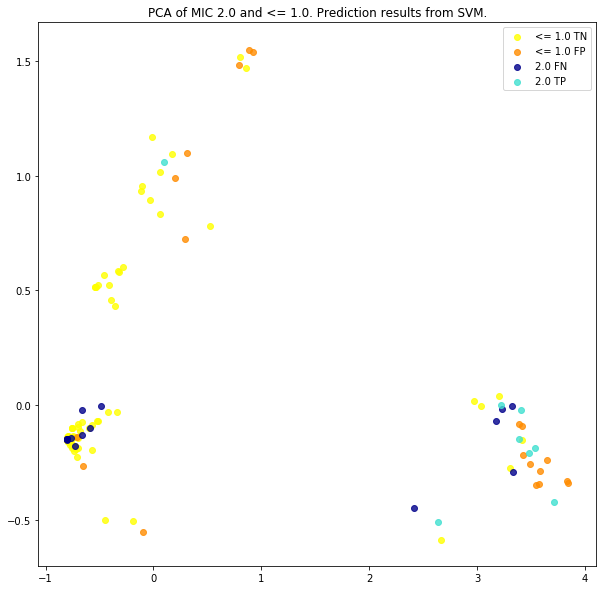

In [35]:
# Visualize relationships between correct/incorrect
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

from sklearn import datasets
from sklearn.decomposition import PCA

# Identify the important features
# bighitters = (np.abs(svm.coef_[0]) > 0.0)
# X_pca = X_test_2[:,bighitters]
X_pca = X_test_fs2 * svm.coef_[0]

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)

names = np.array(["2.0 TP", "2.0 FN", "<= 1.0 TN", "<= 1.0 FP"])
colors = np.array(["turquoise", "darkblue", "yellow", "darkorange"])
data_labels = np.zeros(len(y_test_2))
data_labels[(y_test_2 == 0) & (y_test_2 == y_svm)] = 0
data_labels[(y_test_2 == 0) & (y_test_2 != y_svm)] = 1
data_labels[(y_test_2 == 2) & (y_test_2 == y_svm)] = 2
data_labels[(y_test_2 == 2) & (y_test_2 != y_svm)] = 3
lw = 1

plot_order = [2, 3, 1, 0]

for color, i, target_name in zip(colors[plot_order], plot_order, names[plot_order]):
    plt.scatter(X_r[data_labels == i, 0], X_r[data_labels == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MIC 2.0 and <= 1.0. Prediction results from SVM.')

In [16]:
# Try XGBoost now


In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.1)
xgb.fit(X_train_fs2,y_train_2)
y_xgb = xgb.predict(X_test_fs2)

print(accuracy_score(y_test_2,y_xgb))
print(classification_report(y_test_2,y_xgb))
print(confusion_matrix(y_test_2,y_xgb))

0.8406593406593407
             precision    recall  f1-score   support

          0       0.38      0.33      0.36        24
          2       0.90      0.92      0.91       158

avg / total       0.83      0.84      0.84       182

[[  8  16]
 [ 13 145]]


/home/matt/anaconda3/envs/phenores4/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'PCA of MIC 2.0 and <= 1.0. Prediction results from SVM.')

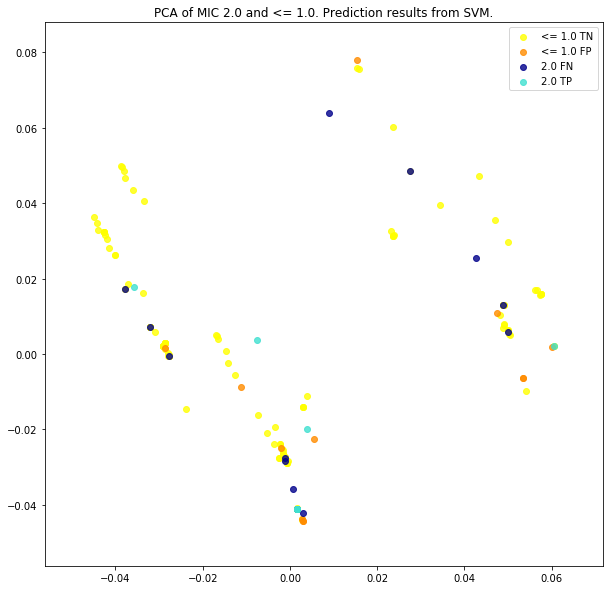

In [38]:
X_pca = X_test_fs2 * xgb.feature_importances_

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)


names = np.array(["2.0 TP", "2.0 FN", "<= 1.0 TN", "<= 1.0 FP"])
colors = np.array(["turquoise", "darkblue", "yellow", "darkorange"])
data_labels = np.zeros(len(y_test_2))
data_labels[(y_test_2 == 0) & (y_test_2 == y_svm)] = 0
data_labels[(y_test_2 == 0) & (y_test_2 != y_svm)] = 1
data_labels[(y_test_2 == 2) & (y_test_2 == y_svm)] = 2
data_labels[(y_test_2 == 2) & (y_test_2 != y_svm)] = 3
lw = 1

plot_order = [2, 3, 1, 0]

for color, i, target_name in zip(colors[plot_order], plot_order, names[plot_order]):
    plt.scatter(X_r[data_labels == i, 0], X_r[data_labels == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MIC 2.0 and <= 1.0. Prediction results from SVM.')

In [20]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="hinge", penalty='l1', max_iter=1000, tol=None)
sgd.fit(X_train_fs2,y_train_2)
y_sgd = sgd.predict(X_test_fs2)

print(accuracy_score(y_test_2,y_sgd))
print(classification_report(y_test_2,y_sgd))
print(confusion_matrix(y_test_2,y_sgd))

0.7527472527472527
             precision    recall  f1-score   support

          0       0.20      0.29      0.24        24
          2       0.88      0.82      0.85       158

avg / total       0.79      0.75      0.77       182

[[  7  17]
 [ 28 130]]


Text(0.5,1,'PCA of MIC 2.0 and <= 1.0. Prediction results from SVM.')

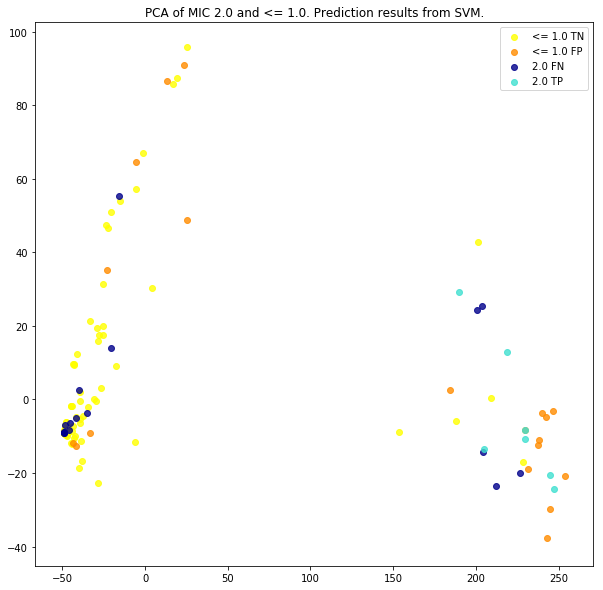

In [21]:
X_pca = X_test_fs2 * sgd.coef_[0]

pca = PCA(n_components=2)
X_r = pca.fit(X_pca).transform(X_pca)


names = np.array(["2.0 TP", "2.0 FN", "<= 1.0 TN", "<= 1.0 FP"])
colors = np.array(["turquoise", "darkblue", "yellow", "darkorange"])
data_labels = np.zeros(len(y_test_2))
data_labels[(y_test_2 == 0) & (y_test_2 == y_svm)] = 0
data_labels[(y_test_2 == 0) & (y_test_2 != y_svm)] = 1
data_labels[(y_test_2 == 2) & (y_test_2 == y_svm)] = 2
data_labels[(y_test_2 == 2) & (y_test_2 != y_svm)] = 3
lw = 1

plot_order = [2, 3, 1, 0]

for color, i, target_name in zip(colors[plot_order], plot_order, names[plot_order]):
    plt.scatter(X_r[data_labels == i, 0], X_r[data_labels == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MIC 2.0 and <= 1.0. Prediction results from SVM.')

In [90]:
# Are there any differences between nearest neighbours?
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X_test_fs2)
distances, indices = nbrs.kneighbors(X_test_fs2)
# FN
fns = np.where((y_test_2 != y_xgb) & (y_test_2 == 0))[0]

print(fns)
print(indices[fns,0])
print(indices[fns,1])
print(distances[fns,])
print(X_test_fs2.shape[1])
print(np.all(X_test_fs2[32,:] == X_test_fs2[126,:]))
print(np.sum(X_test_fs2[2,:] == X_test_fs2[22,:]))
print(np.sum(X_test_fs2[28,:] == X_test_fs2[40,:]))
print(y_test_2[28])
print(y_xgb[28])
print(y_test_2[40])
print(y_xgb[40])

X_test_fs2[40,:] != X_test_fs2[28,:]


[ 20  22  28  52  54  64  69  79 124 126 136 153 154 162 164 170]
[ 20  22  28  52  54  64  69  79 124  32 136  21  97 162 164 170]
[ 47   2  40  80  31 180  81  40  33  31  44 153  48 111  81   2]
[[0.         2.82842712]
 [0.         1.        ]
 [0.         5.29150262]
 [0.         5.19615242]
 [0.         1.        ]
 [0.         5.83095189]
 [0.         1.41421356]
 [0.         5.38516481]
 [0.         3.74165739]
 [0.         0.        ]
 [0.         1.73205081]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         4.35889894]
 [0.         2.23606798]]
270
True
269
242
0
2
0
0


28

In [46]:
indices

array([[  0,  25],
       [ 32,  31],
       [  2,  89],
       [  3,  66],
       [117,   4],
       [ 32,  31],
       [  6,  39],
       [ 32,  31],
       [  8,  56],
       [  9, 163],
       [ 32,  31],
       [ 32,  31],
       [ 12,  80],
       [ 13,  41],
       [ 14,  31],
       [ 32,  31],
       [ 32,  31],
       [ 17,  48],
       [ 18,  41],
       [ 32,  31],
       [ 20,  47],
       [ 21, 153],
       [ 22,   2],
       [ 23, 174],
       [ 32,  31],
       [ 25,  31],
       [ 26,  31],
       [ 27,  45],
       [ 28,  40],
       [ 29,  31],
       [ 30,  31],
       [ 32,  31],
       [ 32,  31],
       [ 33, 124],
       [ 34,  56],
       [ 35,  45],
       [ 32,  31],
       [ 37,  89],
       [ 32,  31],
       [ 39,   6],
       [ 40, 173],
       [ 41, 127],
       [ 42,  27],
       [ 43,  82],
       [ 44, 113],
       [ 45,  31],
       [ 46, 108],
       [ 47,  20],
       [ 97,  48],
       [ 32,  31],
       [ 32,  31],
       [ 51,  31],
       [ 52,

In [103]:
# Try RBF kernal SVM
from sklearn.svm import SVC
svc = SVC(gamma=1000000000000000000, C=1, kernel='rbf')
svc.fit(X_train_fs2,y_train_2)
y_svc = sgd.predict(X_test_fs2)

print(accuracy_score(y_test_2,y_svc))
print(classification_report(y_test_2,y_svc))
print(confusion_matrix(y_test_2,y_svc))

0.7527472527472527
             precision    recall  f1-score   support

          0       0.20      0.29      0.24        24
          2       0.88      0.82      0.85       158

avg / total       0.79      0.75      0.77       182

[[  7  17]
 [ 28 130]]


In [117]:
print(kmers.shape)
print(kmers.nbytes / 1e9)

(1406, 1922478)
2.703004068


In [116]:
kmers.nbytes

2703004068